# Imports

In [37]:
!pip install -q kornia
!pip install -q wandb
!pip install -q torchmetrics
!pip install -q einops
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

import torch
from torchvision import transforms
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch.autograd import Variable
import math
from math import exp
from tqdm import tqdm

from kornia.filters.sobel import Sobel
import wandb
from torchvision.utils import make_grid
import gc
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM



from torch.nn.parameter import Parameter
from einops import rearrange
from torch.nn import init 

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loss, Metric and Other Functions

In [39]:
def normalize(sample):
    MIN_H = sample.min()
    MAX_H = sample.max()
    return (sample - MIN_H)/(MAX_H-MIN_H)

In [40]:
class Sobel_older(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=False)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
#         x = (torch.tanh(x) + 1)/2
        return x

In [41]:
def calculate_psnr(img1, img2, border=0 ,data_min=0.0 ,data_max=1.0 ):
    
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[2:]

    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    mse = np.mean((img1 - img2)**2)
#     print(mse)
    if mse == 0:
        return float('inf')
    return 20 * math.log10((data_max - data_min)/ math.sqrt(mse))

In [42]:
class gradientAwareLoss(nn.Module): 
    def __init__(self):
        super().__init__()
        self.sobelFilter = Sobel().to('cuda')
        self.l1Loss = nn.L1Loss().to('cuda')

    def forward(self, hr, sr):
        hrEdgeMap = self.sobelFilter(hr)
        srEdgeMap = self.sobelFilter(sr)
        return self.l1Loss(hrEdgeMap, srEdgeMap)  

In [43]:
sobel_old = Sobel_older()
inp = torch.rand([1,1,256,256])
out = sobel_old(inp)
print(out.shape)

torch.Size([1, 1, 254, 254])


# Dataset and Dataloader¶

In [8]:
# # Dataset class
# class Dataset(data.Dataset):
#     def __init__(self, load_dir, normalize = True,transform=transforms.Compose([transforms.ToTensor()])):
#         self.load_dir = load_dir
#         self.tranform = transform
#         self.downsampler = torch.nn.Upsample(scale_factor=0.5, mode='bilinear')
#         self.normalize = normalize      
#     def __getitem__(self, idx):        
#         try:
#             if self.normalize:
#                 im = normalize(torch.load(self.load_dir[idx]))
#             else:
#                 im = torch.load(self.dems[idx])
#             HR = im.copy().astype(np.float32) 
#             HR = torch.from_numpy(HR).unsqueeze(0) 
            
#             # print("shape of LR", LR.shape)
#             LR = self.downsampler(HR.unsqueeze(0)).squeeze()     
#             # print("shape of LR", LR.shape)
#             return HR, LR.unsqueeze(0)
#         except:
#             print(idx)
#             print(self.load_dir[idx])
#     def __len__(self):
#         return len(self.load_dir)

In [44]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import torchvision.transforms as transforms
import random
import cv2
import os

def custom_collate(batch):
    """
    Custom collate function to filter out None values
    """
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

class Dataset(data.Dataset):
    def __init__(self, load_dir, normalize=True, transform=transforms.Compose([transforms.ToTensor()]),
                 downsample_methods=['bilinear', 'bicubic', 'area', 'gaussian','motion_blur','median_blur']):
        """
        Args:
            load_dir (list): List of paths to high-resolution images
            normalize (bool): Whether to normalize the images
            transform (torchvision.transforms): Additional transformations
            downsample_methods (list): List of downsampling methods to use
        """
        self.load_dir = load_dir
        self.transform = transform
        self.normalize = normalize
        self.downsample_methods = downsample_methods
        
        # Predefined downsampling methods
        self.downsamplers = {
            'bilinear': self._bilinear_downsample,
            'bicubic': self._bicubic_downsample,
            'area': self._area_downsample,
            'gaussian': self._gaussian_downsample,
            'motion_blur': self._motion_blur_downsample,
            'median_blur': self._median_blur_downsample
        }
    
    def _bilinear_downsample(self, HR):
        """Bilinear downsampling"""
        return torch.nn.functional.interpolate(HR.unsqueeze(0), scale_factor=0.5, mode='bilinear').squeeze()
    
    def _bicubic_downsample(self, HR):
        """Bicubic downsampling"""
        return torch.nn.functional.interpolate(HR.unsqueeze(0), scale_factor=0.5, mode='bicubic').squeeze()
    
    def _area_downsample(self, HR):
        """Area interpolation downsampling"""
        return torch.nn.functional.interpolate(HR.unsqueeze(0), scale_factor=0.5, mode='area').squeeze()
    
    def _gaussian_downsample(self, HR):
        """Gaussian blur + downsampling"""
        hr_np = HR.squeeze(0).numpy() 
        blurred = cv2.GaussianBlur(hr_np, (5, 5), 0)
        downsampled = cv2.resize(blurred, (HR.shape[2]//2, HR.shape[1]//2), interpolation=cv2.INTER_AREA)
        return torch.from_numpy(downsampled).unsqueeze(0) 
    
    def _motion_blur_downsample(self, HR):
        """Motion blur + downsampling"""
        hr_np = HR.squeeze(0).numpy() 
        kernel_size = 5
        kernel_v = np.zeros((kernel_size, kernel_size))
        kernel_v[:, kernel_size // 2] = np.ones(kernel_size)
        kernel_v /= kernel_size
        blurred = cv2.filter2D(hr_np, -1, kernel_v)
        downsampled = cv2.resize(blurred, (HR.shape[2]//2, HR.shape[1]//2), interpolation=cv2.INTER_AREA)
        return torch.from_numpy(downsampled).unsqueeze(0)  # Add channel back

    
    def _median_blur_downsample(self, HR):
        """Median blur + downsampling"""
        hr_np = HR.squeeze(0).numpy() 
        blurred = cv2.medianBlur(hr_np.astype(np.uint8), 5)
        downsampled = cv2.resize(blurred, (HR.shape[2]//2, HR.shape[1]//2), interpolation=cv2.INTER_AREA)
        return torch.from_numpy(downsampled).unsqueeze(0)  # Add channel back

    
    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(f"Index {idx} is out of range")
        
        try:
            image_path = self.load_dir[idx]
            
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image file not found: {image_path}")
            
            im = torch.load(image_path)
            
            if self.normalize:
                im = normalize(im)
            
            if not isinstance(im, torch.Tensor):
                im = torch.tensor(im, dtype=torch.float32)
            
            if im.dim() == 2:
                im = im.unsqueeze(0)
            
            HR = im.float()
            
            downsample_method = random.choice(self.downsample_methods)
            
            LR = self.downsamplers[downsample_method](HR)
            
            HR = HR.squeeze()
            LR = LR.squeeze().float()
            
#             print("method : " , downsample_method)
#             print("LR : ", LR.shape)
#             print("HR : ", HR.shape)
            
            return HR.unsqueeze(0), LR.unsqueeze(0)
        
        except Exception as e:
            print(f"Error processing image at index {idx}")
            print(f"Image path: {self.load_dir[idx]}")
            print(f"Error details: {type(e).__name__}: {str(e)}")
            
            return None
    
    def __len__(self):
        return len(self.load_dir)

In [45]:
train_dir = glob.glob('../data_DEMs_no_nan/train/*.pt')
test_dir = glob.glob('../data_DEMs_no_nan/test/*.pt')

test_dir.remove('../data_DEMs_no_nan/test/NAC_DTM_MESSIER3_block_211.pt')

print(len(train_dir))
print(len(test_dir))

1172
1673


In [11]:
trainset = Dataset(load_dir = train_dir)
testset  = Dataset(load_dir = test_dir)

trainloader = DataLoader(trainset,batch_size=4,shuffle=True)
testloader = DataLoader(testset,batch_size=4,shuffle=False)

In [46]:
for idx, (hr, lr) in enumerate(testloader):
    if hr is None or lr is None:
        continue  
    print(lr.shape)
    break


torch.Size([4, 1, 128, 128])


In [47]:
len(testloader)

419

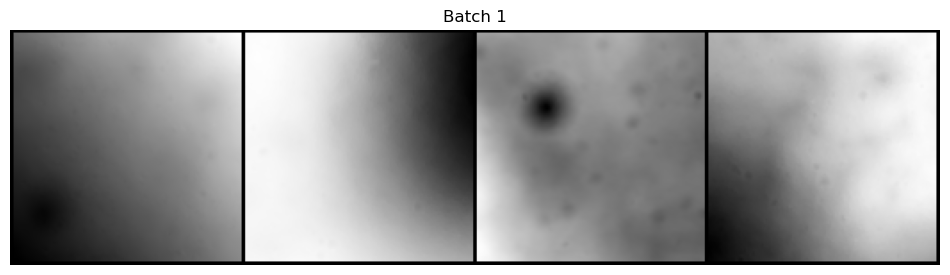

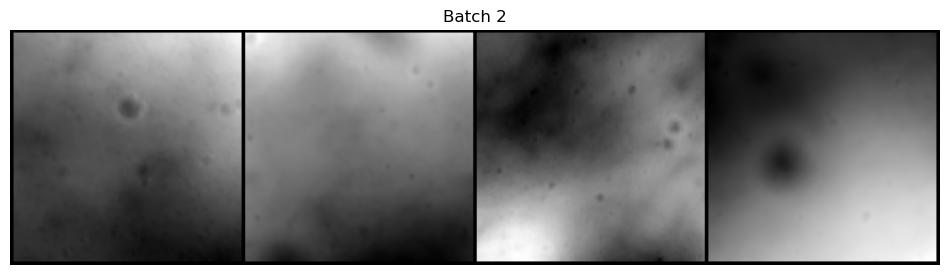

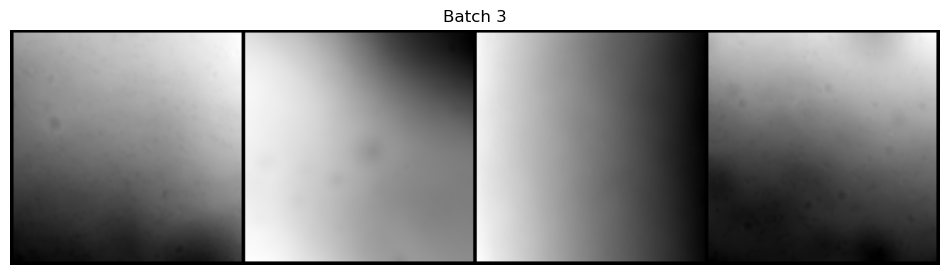

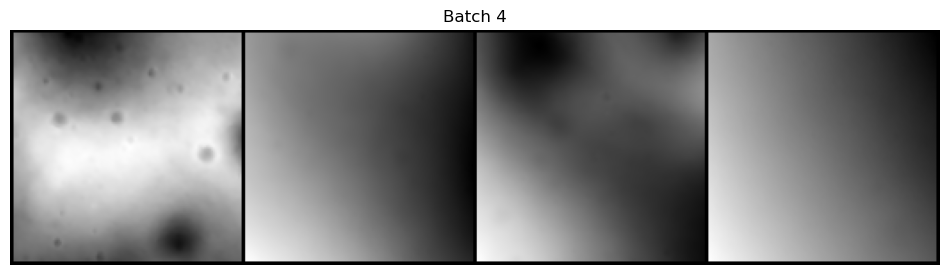

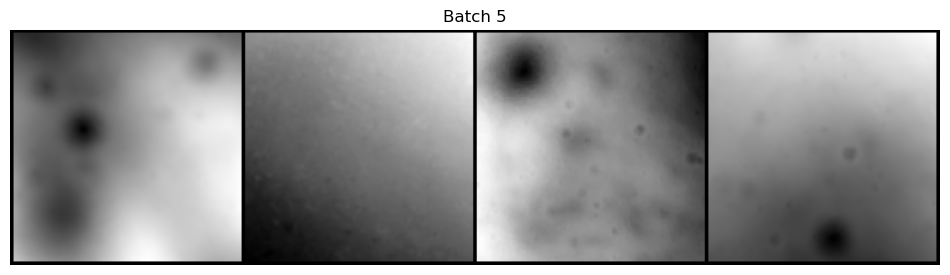

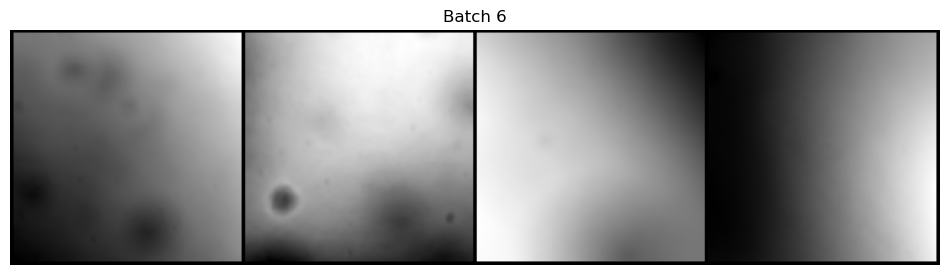

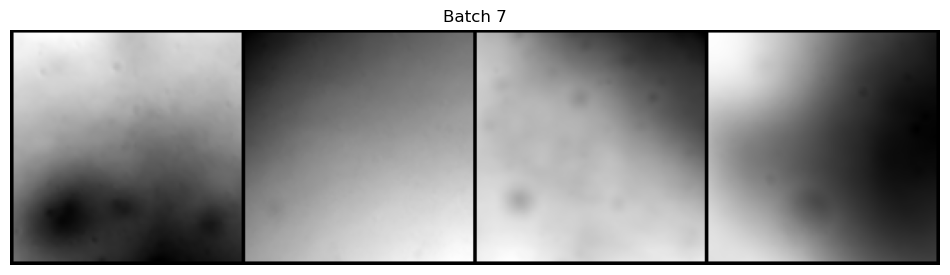

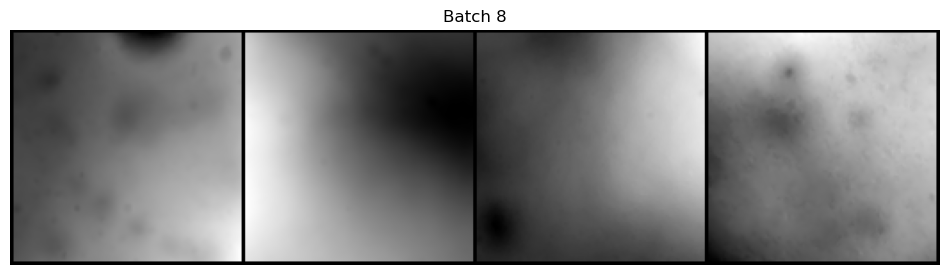

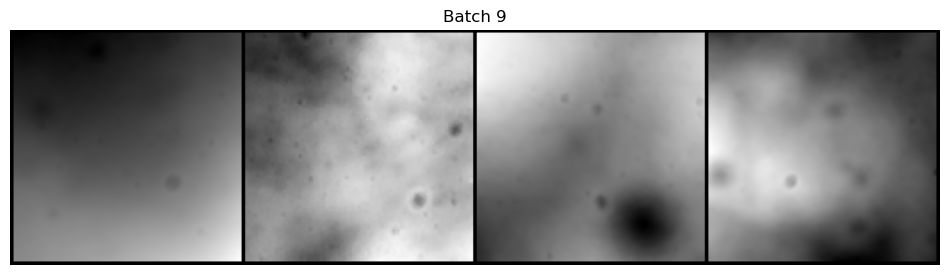

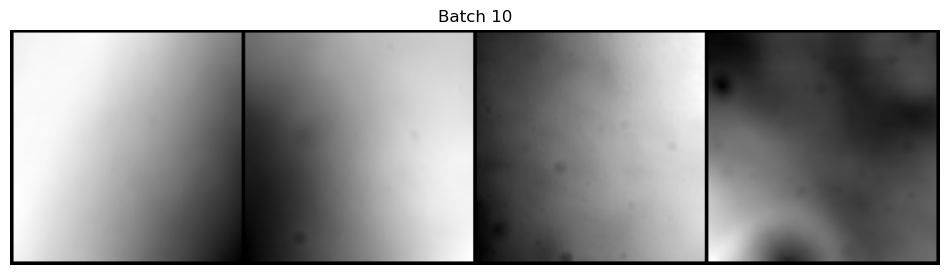

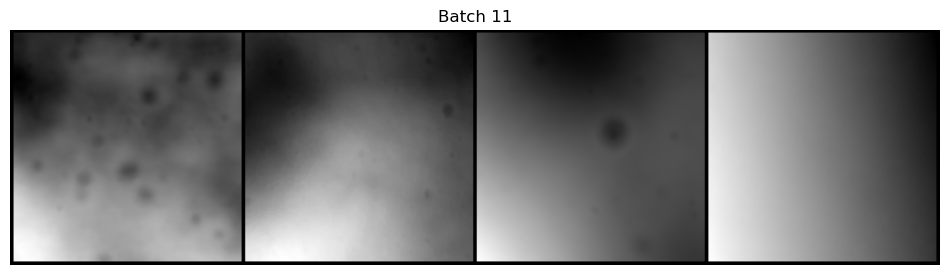

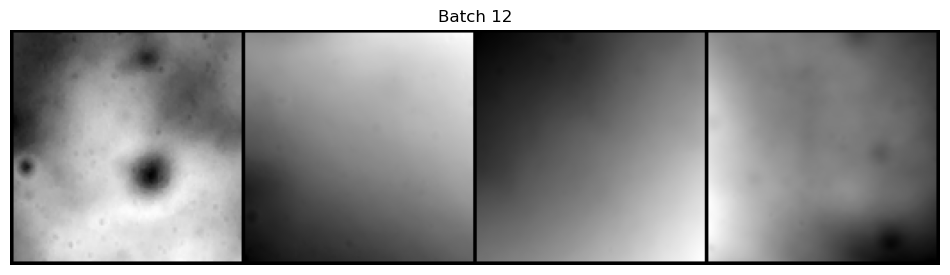

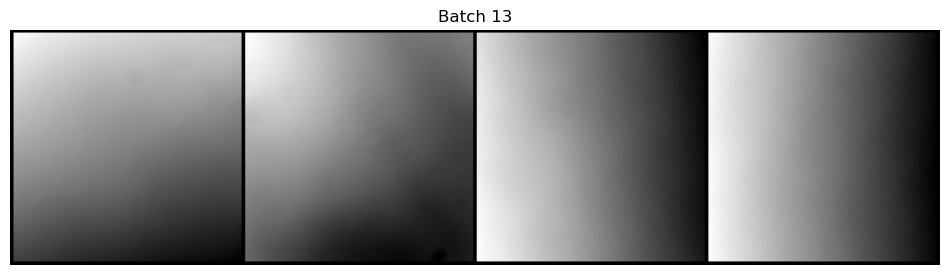

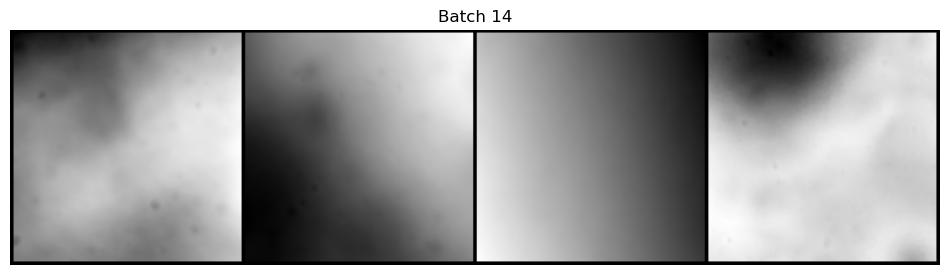

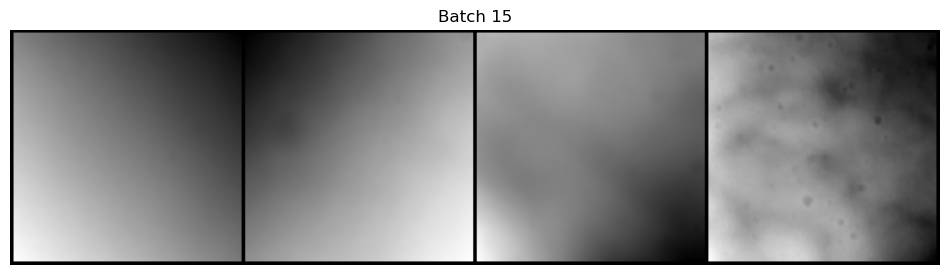

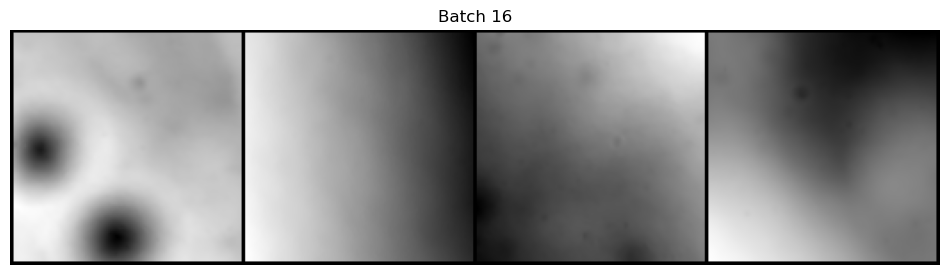

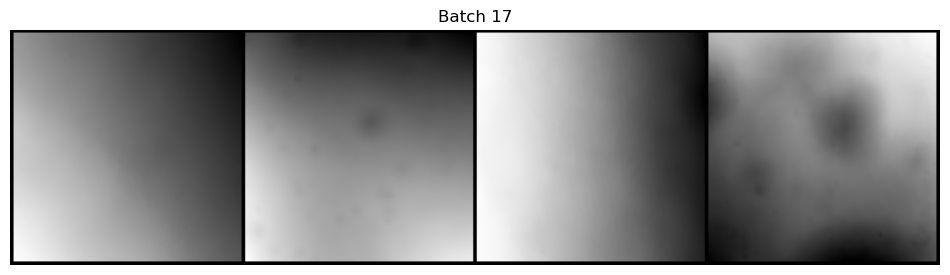

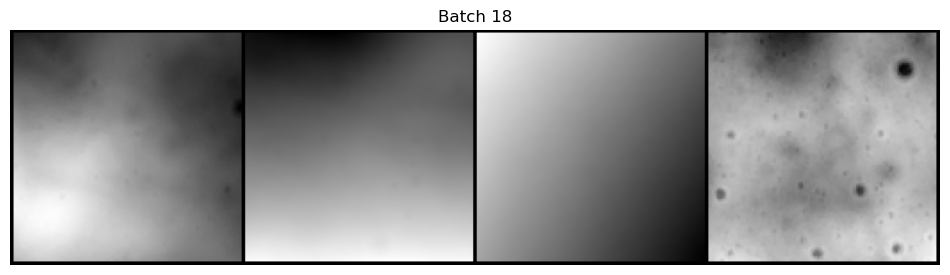

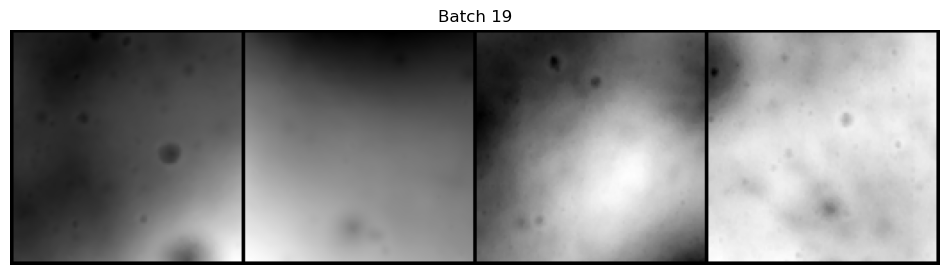

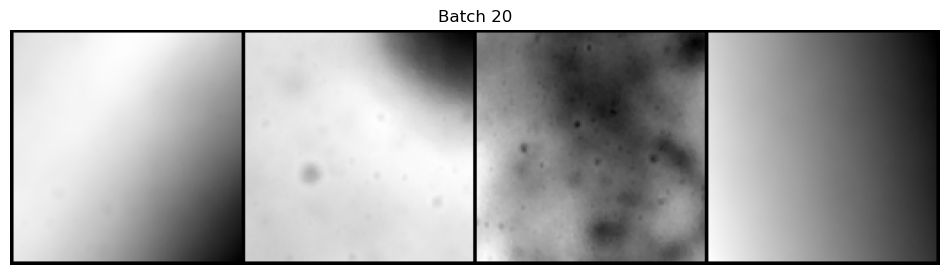

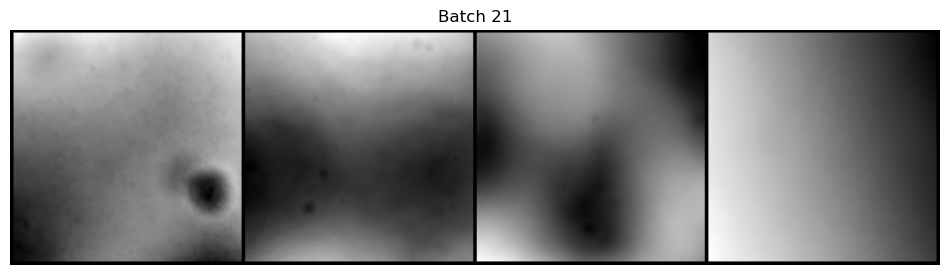

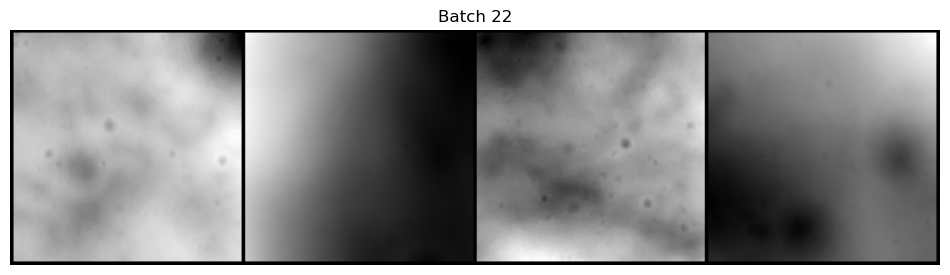

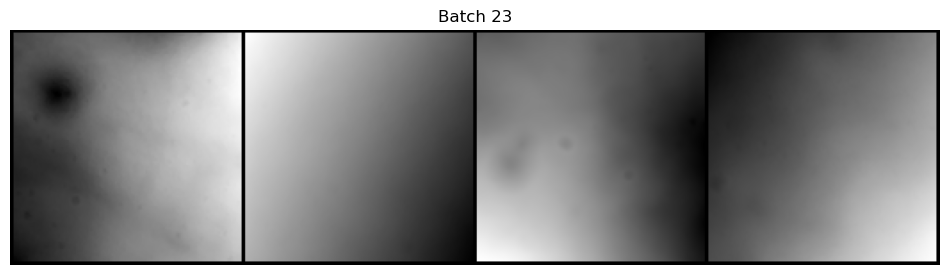

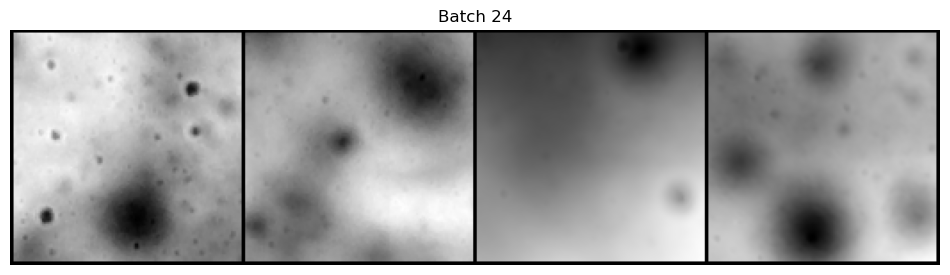

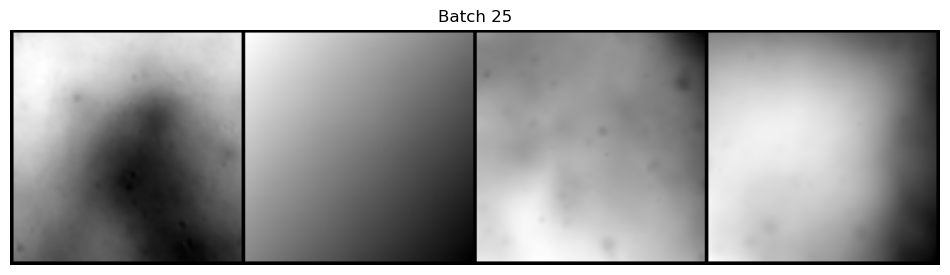

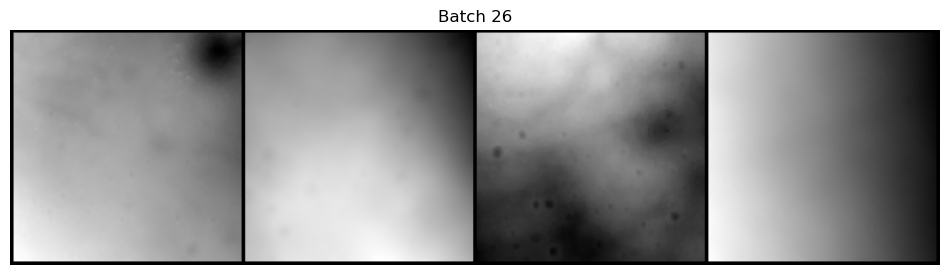

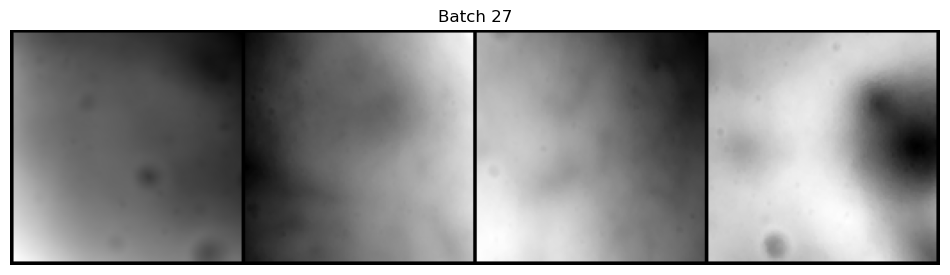

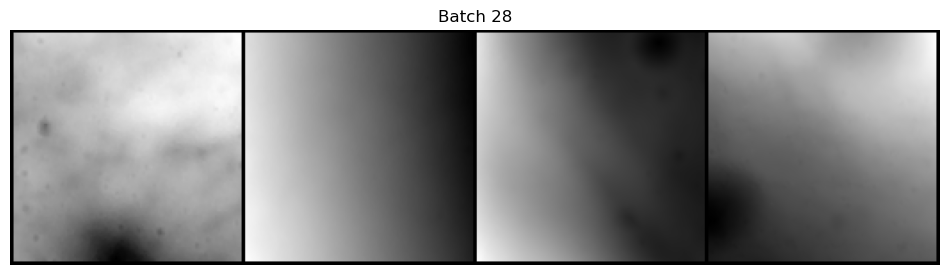

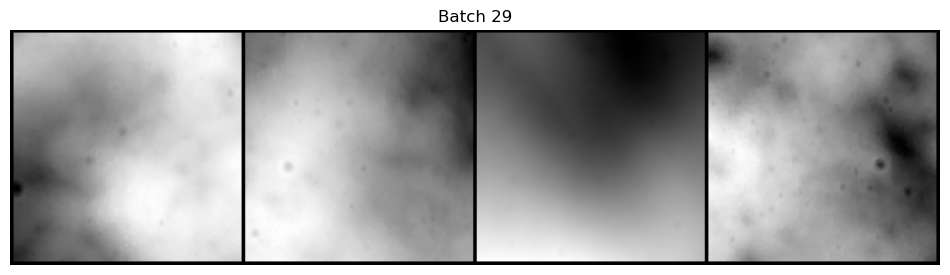

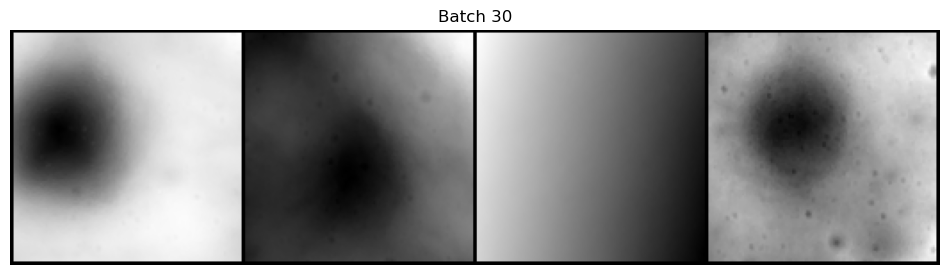

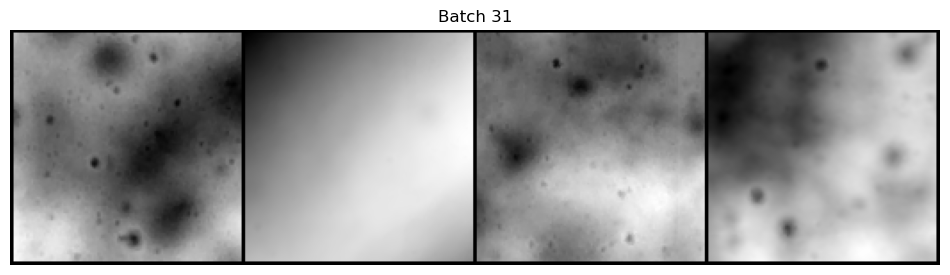

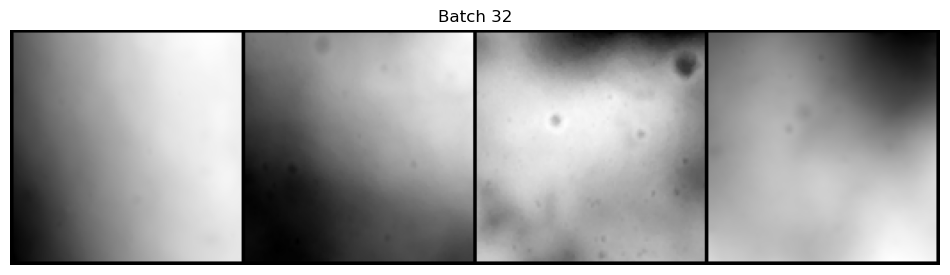

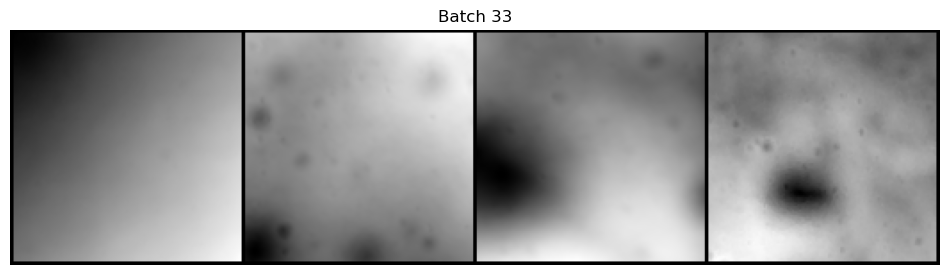

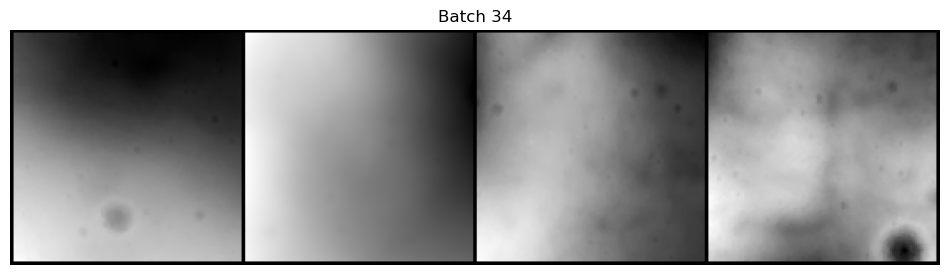

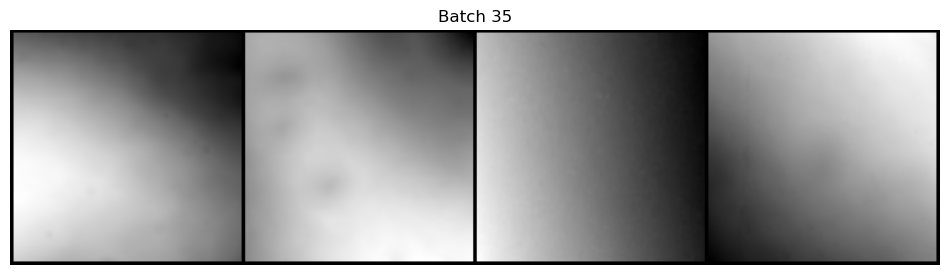

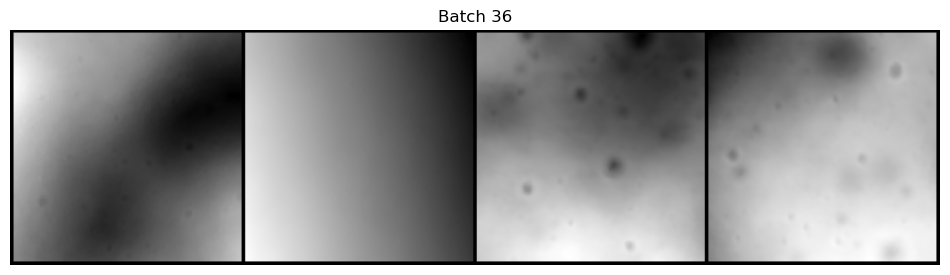

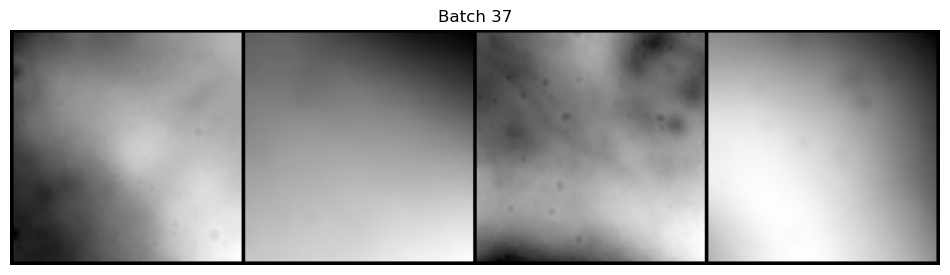

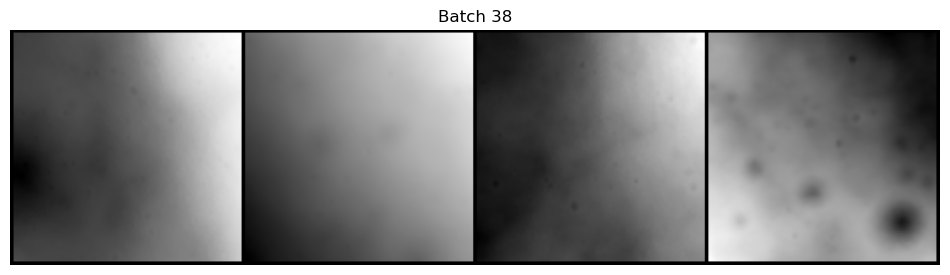

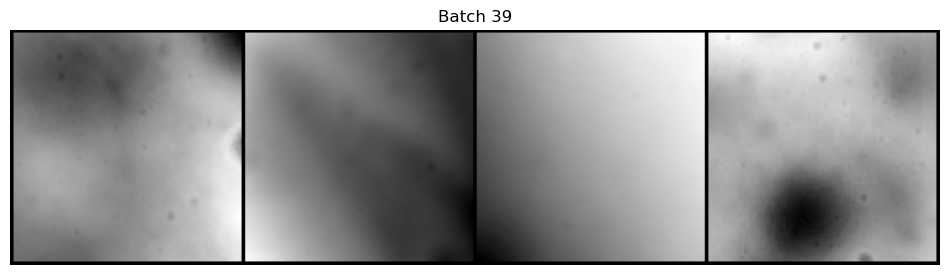

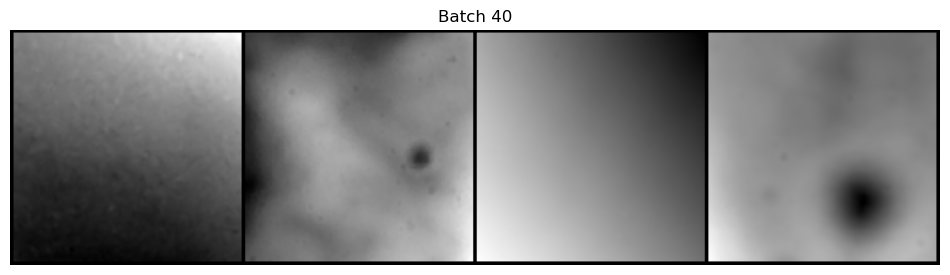

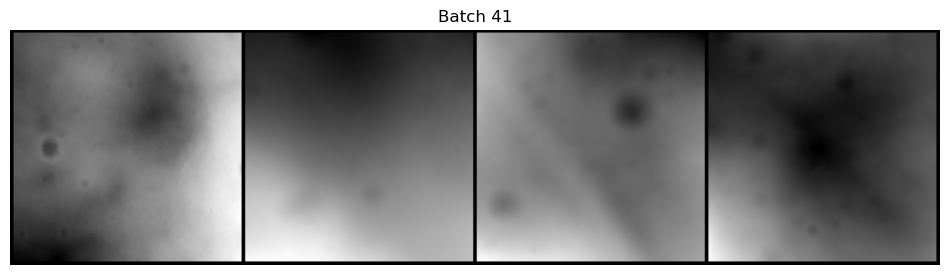

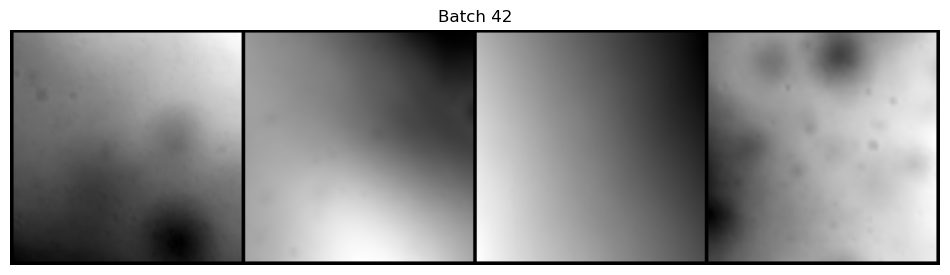

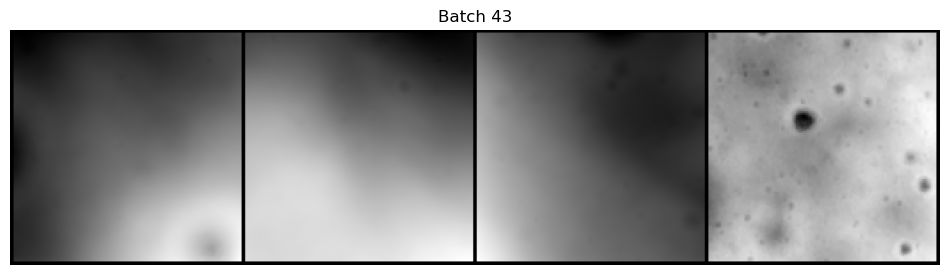

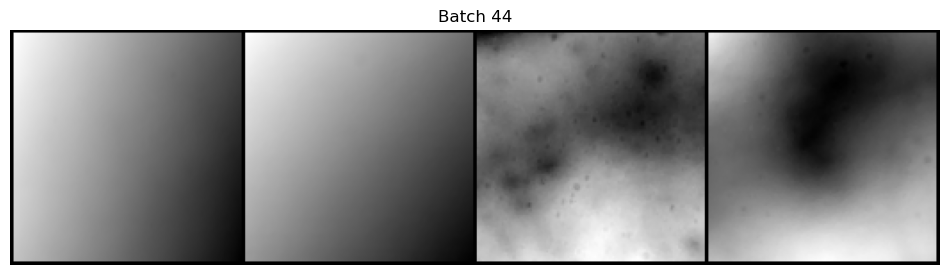

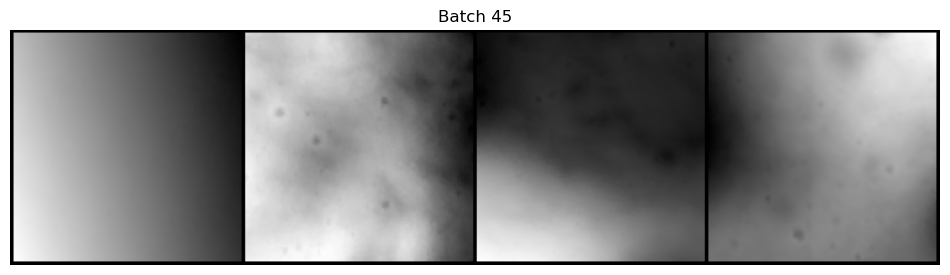

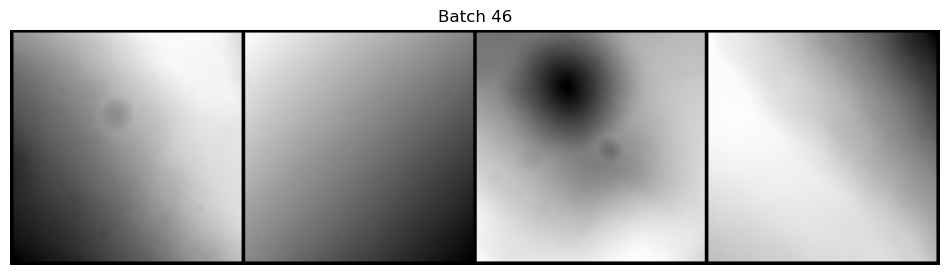

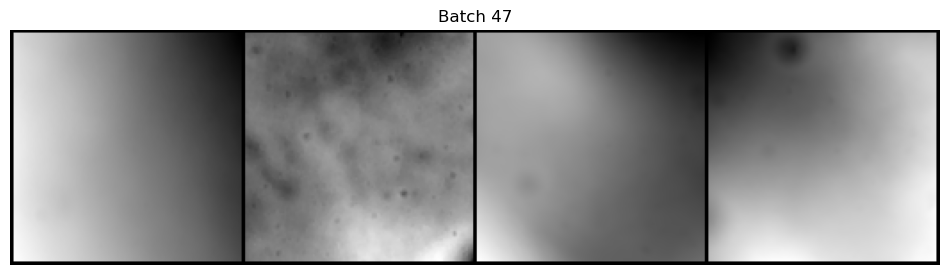

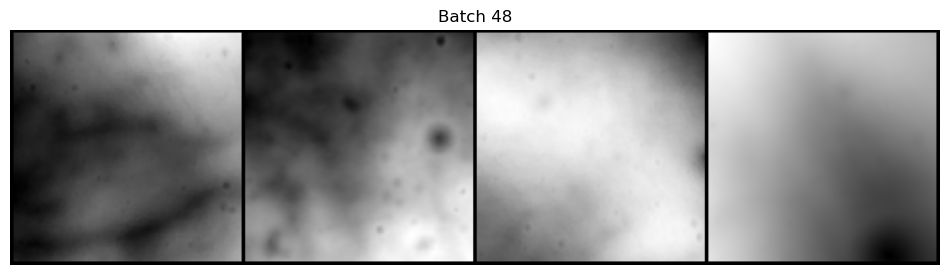

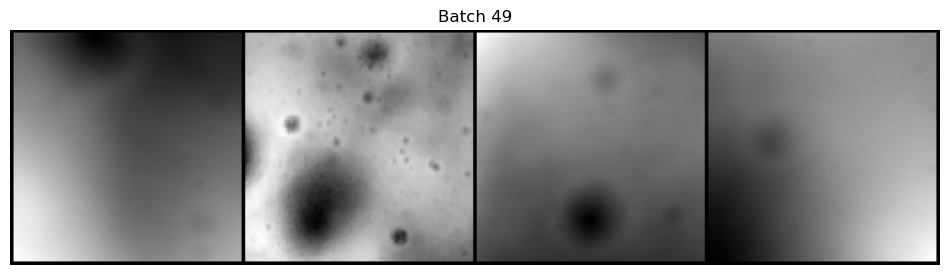

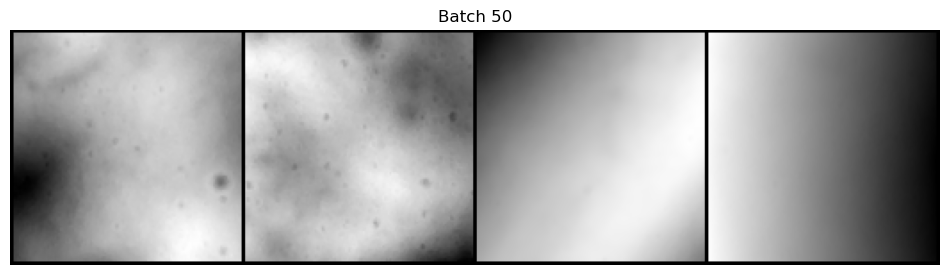

In [49]:
import matplotlib.pyplot as plt
import torchvision

def visualize_dataloader(dataloader, n_batches=5, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Visualize images from a DataLoader.

    Args:
        dataloader: PyTorch DataLoader object.
        n_batches: Number of batches to visualize.
        mean: Mean used for normalization.
        std: Standard deviation used for normalization.
    """
    batch_count = 0

    for _, images in dataloader:
        if batch_count >= n_batches:
            break
        
        # Denormalize images if necessary
        images = torchvision.utils.make_grid(images, nrow=images.shape[0])
        images = images.permute(1, 2, 0).numpy()  # Convert to HWC format
        # images = (images * std + mean).clip(0, 1)  # Denormalize and clip
        
        # Plot the images
        plt.figure(figsize=(12, 6))
        plt.imshow(images)
        plt.axis("off")
        plt.title(f"Batch {batch_count + 1}")
        plt.show()

        batch_count += 1
visualize_dataloader(trainloader, n_batches=50)

torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 128, 128])
tensor(0.)
tensor(1.)
tensor(0.0007)
tensor(0.9991)


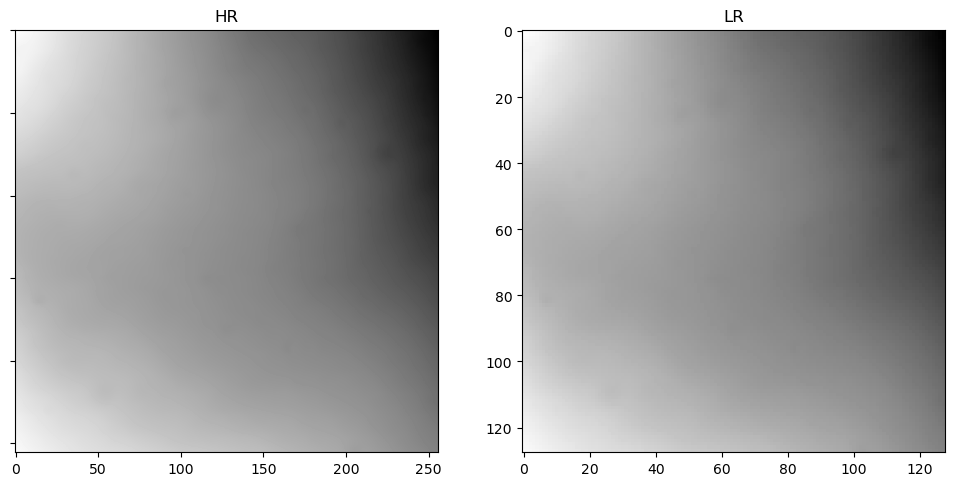

In [50]:
# visualization 
for b, (hr, lr) in enumerate(trainloader):
    print(hr.shape)
    print(lr.shape)
    
    print(hr.min())
    print(hr.max())
    
    print(lr.min())
    print(lr.max())
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

    axes[0].set_yticklabels([])

    axes[0].imshow(hr[2].squeeze(), cmap='gray')
    axes[1].imshow(lr[2].squeeze(), cmap='gray')
    
    axes[0].set_title("HR")
    axes[1].set_title("LR")
    

    break

# Model

In [51]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size = 3, padding = 1, bias=False):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=padding, groups=nin, bias=bias)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ERAM(nn.Module):
    def __init__(self, channel_begin, dimension):
        super().__init__()
        self.conv = nn.Conv2d(channel_begin, channel_begin, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(dimension)
        
        self.conv1 = nn.Conv2d(channel_begin, channel_begin//2, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(channel_begin//2, channel_begin, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(channel_begin, channel_begin, kernel_size=3, stride=1, padding=1)

        self.dconv = depthwise_separable_conv(channel_begin, channel_begin, kernel_size = 3, padding = 1, bias=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        si_ca = self.avgpool(x) + torch.var_mean(x, dim=(2,3))[0].unsqueeze(2).unsqueeze(2)
        mi_ca = self.conv2(self.relu(self.conv1(si_ca)))

        mi_sa = self.conv3(self.relu(self.dconv(x)))

        return self.sigmoid(mi_ca+mi_sa) * x

    

class SelfAttn(nn.Module):
    def __init__(self, dim, num_heads=8, bias=False):
        super(SelfAttn, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj_out = nn.Linear(dim, dim)

    def forward(self, x):
        b, N, c = x.shape

        qkv = self.qkv(x).chunk(3, dim=-1)
        # [b, N, c] -> [b, N, head, c//head] -> [b, head, N, c//head]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), qkv)

        # [b, head, N, c//head] * [b, head, N, c//head] -> [b, head, N, N]
        attn = torch.einsum('bijc, bikc -> bijk', q, k) * self.scale
        attn = attn.softmax(dim=-1)
        # [b, head, N, N] * [b, head, N, c//head] -> [b, head, N, c//head] -> [b, N, head, c//head]
        x = torch.einsum('bijk, bikc -> bijc', attn, v)
        x = rearrange(x, 'b i j c -> b j (i c)')
        x = self.proj_out(x)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, mlp_ratio=4):
        super(Mlp, self).__init__()
        hidden_features = in_features * mlp_ratio

        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.GELU(),
            nn.Linear(hidden_features, in_features)
        )

    def forward(self, x):
        return self.fc(x)


def window_partition(x, window_size):
    """
    Args:
        x: (b, h, w, c)
        window_size (int): window size
    Returns:
        windows: (num_windows*b, window_size, window_size, c) [non-overlap]
    """
    return rearrange(x, 'b (h s1) (w s2) c -> (b h w) s1 s2 c', s1=window_size, s2=window_size)


def window_reverse(windows, window_size, h, w):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        h (int): Height of image
        w (int): Width of image
    Returns:
        x: (b, h, w, c)
    """
    b = int(windows.shape[0] / (h * w / window_size / window_size))
    return rearrange(windows, '(b h w) s1 s2 c -> b (h s1) (w s2) c', b=b, h=h // window_size, w=w // window_size)


class Transformer(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8, mlp_ratio=4, qkv_bias=False):
        super(Transformer, self).__init__()
        self.window_size = window_size
        self.pos_embed = nn.Conv2d(dim, dim, 3, padding=1, groups=dim)

        self.norm1 = nn.LayerNorm(dim)
        self.attn = SelfAttn(dim, num_heads, qkv_bias)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = Mlp(dim, mlp_ratio)
        # self.rrdBAtt = RRDBAttention(256,32)


    def forward(self, x):
        x = x + self.pos_embed(x)
        x = rearrange(x, 'b c h w -> b h w c')
        b, h, w, c = x.shape

        shortcut = x
        x = self.norm1(x)

        pad_l = pad_t = 0
        pad_r = (self.window_size - w % self.window_size) % self.window_size
        pad_b = (self.window_size - h % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape

        x_windows = window_partition(x, self.window_size)  # nW*B, window_size, window_size, c
        x_windows = rearrange(x_windows, 'B s1 s2 c -> B (s1 s2) c', s1=self.window_size,
                              s2=self.window_size)  # nW*b, window_size*window_size, c

        # W-MSA/SW-MSA
        # print("shape before : ",x_windows.shape)
        attn_windows = self.attn(x_windows)  # nW*b, window_size*window_size, c

        # x_windows = x_windows.view(b,256,64,-1)

        # attn_windows = self.rrdBAtt(x_windows)

        attn_windows = attn_windows.reshape(b*256,64,-1)

        # print("shape after : ",x_windows.shape)
        # merge windows
        attn_windows = rearrange(attn_windows, 'B (s1 s2) c -> B s1 s2 c', s1=self.window_size, s2=self.window_size)
        x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # b H' W' c

        # reverse cyclic shift
        if pad_r > 0 or pad_b > 0:
            x = x[:, :h, :w, :].contiguous()

        x = x + shortcut
        x = x + self.mlp(self.norm2(x))
        return rearrange(x, 'b h w c -> b c h w')


class ResBlock(nn.Module):
    def __init__(self, in_features, ratio=4):
        super(ResBlock, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_features, in_features * ratio, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_features * ratio, in_features * ratio, 3, 1, 1, groups=in_features * ratio),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_features * ratio, in_features, 1, 1, 0),
        )

    def forward(self, x):
#         print(x.shape)
        return self.net(x) + x


class BaseBlock(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=8, ratios=[1, 2, 2, 4, 4], qkv_bias=False):
        super(BaseBlock, self).__init__()
        self.layers = nn.ModuleList([])
        # self.eram = ERAM(dim,128)
#         print('dim : ',dim)
        for ratio in ratios:
            self.layers.append(nn.ModuleList([
                Transformer(dim, num_heads, window_size, ratio, qkv_bias),
                ResBlock(dim, ratio),
                ERAM(dim,128)
            ]))

    def forward(self, x):
        for tblock, rblock ,eram in self.layers:
            x = tblock(x)
            x = rblock(x)
            x = eram(x)
        return x


class SRModel(nn.Module):
    def __init__(self, n_feats=40, n_heads=8, ratios=[4, 2, 2, 2, 4], upscaling_factor=2):
        super(SRModel, self).__init__()
        self.scale = upscaling_factor
        self.head = nn.Conv2d(1, n_feats, 3, 1, 1)

        self.body = BaseBlock(n_feats, num_heads=n_heads, ratios=ratios)

        self.fuse = nn.Conv2d(n_feats * 2, n_feats, 3, 1, 1)

        if self.scale == 4:
            self.upsapling = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 4, 1, 1, 0),
                nn.PixelShuffle(2),
                nn.Conv2d(n_feats, n_feats * 4, 1, 1, 0),
                nn.PixelShuffle(2)
            )
        else:
            self.upsapling = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * self.scale * self.scale, 1, 1, 0),
                nn.PixelShuffle(self.scale)
            )

        self.tail = nn.Conv2d(n_feats, 1, 3, 1, 1)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x0 = self.head(x)
        x0 = self.fuse(torch.cat([x0, self.body(x0)], dim=1))
        x0 = self.upsapling(x0)
        x0 = self.tail(self.act(x0))
        x = F.interpolate(x, scale_factor=self.scale, mode='bicubic', align_corners=False)
        return (torch.tanh(x0 + x) +1.0)/2.0

network = SRModel()
# model = RRDBAttention(1024,32)
# print(summary(model,input_size=[1,1,128,128]))
inp = torch.rand([1,1,128,128])
out = network(inp)
print(out.shape)

torch.Size([1, 1, 256, 256])


In [52]:
network = network.to(device)

In [53]:
class Blocks(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(Blocks, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels, features):
        super(Discriminator, self).__init__()
        self.first_layer= nn.Sequential(
            nn.Conv2d(in_channels, features, 3, 2 ,1),
            nn.LeakyReLU(0.2),
        )
        self.Block1 = Blocks(features, features*2, stride=2)
        self.Block2 = Blocks(features*2, features*2, stride=1)
        self.Block3 = Blocks(features*2, features*4, stride=2)
        self.Block4 = Blocks(features*4, features*4, stride=1)
        self.Block5 = Blocks(features*4, features*8, stride=2)
        self.Block6 = Blocks(features*8, features*8, stride=1)
        self.Block7 = Blocks(features*8, features*8, stride=2)
        self.Block8 = Blocks(features*8, features*8, stride=2)
        self.Block9 = nn.Sequential(
            nn.Conv2d(features*8, features*4, 3, 2, 1),
        
            nn.LeakyReLU(0.2),
        )
        self.final_layer = nn.Sequential(
            nn.Linear(features*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x =  self.first_layer(x)
        x =  self.Block1(x)
        x =  self.Block2(x)
        x =  self.Block3(x)
        x =  self.Block4(x)
        x =  self.Block5(x)
        x =  self.Block6(x)
        x =  self.Block7(x)
        x =  self.Block8(x)
        x = self.Block9(x)
        x = x.view(x.size(0), -1)
        return self.final_layer(x)

In [54]:
generator = SRModel()
generator = generator.to(device)
generator.load_state_dict(torch.load('best_model_31.023601373866665.pt'))
discriminator = Discriminator(1, 128)
discriminator = discriminator.to(device)

# Training 

In [55]:
wandb.init(project="data_Dem_pretrained_wt_mutlpleDownsampling", name="EXP-5")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ec2-user/.netrc


In [56]:
l1Loss = nn.L1Loss().to(device) 
edgeLoss = gradientAwareLoss().to(device) 
ssim = SSIM(data_range=1.0).to(device) 
anotherl1Loss = nn.L1Loss().to(device) 

# optimizer = torch.optim.Adam(network.parameters(), lr=5e-6 
optim_G = torch.optim.Adam(generator.parameters(), lr=0.00001)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.00001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [57]:
scaler = torch.cuda.amp.GradScaler()

In [58]:
sobelFilter = Sobel().to('cuda')

In [59]:
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM
ssim = SSIM(data_range=1.0).to('cuda')
inp1 = torch.rand([1,1,256,256])
inp2 = torch.rand([1,1,256,256])
out = ssim(inp1,inp2)
out

tensor(0.0138, device='cuda:0')

In [60]:

num_train_batches = float(len(trainloader))
num_val_batches = float(len(testloader))

def train_one_epoch(epoch):
    print(f"Epoch {epoch}: ", end ="")
    
    l1_loss_per_epoch = 0.0
    edge_loss_per_epoch = 0.0
    ssim_loss_per_epoch = 0.0
    ssim_per_epoch = 0.0
    psnr_per_epoch = 0.0
    total_loss_per_epoch = 0.0
    D_adv_loss = 0
    
    generator.train()
    for batch, (hr, lr) in enumerate(tqdm(trainloader)):

        for p in discriminator.parameters():
            p.requires_grad = False
        #training generator
        optim_G.zero_grad()
 
        lr_images = lr.to(device)
        hr_images = hr.to(device)
        lr_images = lr_images.float()
        predicted_hr_images = generator(lr_images)
        predicted_hr_labels = discriminator(predicted_hr_images)
        gf_loss = F.binary_cross_entropy_with_logits(predicted_hr_labels, torch.ones_like(predicted_hr_labels)) #adverserial loss
      
      
        # reconstruction loss    
      
        l1_loss_per_sample = l1Loss(hr_images*1000, predicted_hr_images*1000)
        ssim_per_sample = ssim(hr_images, predicted_hr_images)
        ssim_loss_per_sample = 1 - ssim_per_sample
        edge_loss = edgeLoss(hr_images*1000, predicted_hr_images*1000)  
        reconstruction_loss = l1_loss_per_sample + 100*(ssim_loss_per_sample) + 50*edge_loss
        t_loss = reconstruction_loss + 50*gf_loss
        
      
        t_loss.backward()
        optim_G.step()
      
        psnr_per_sample = calculate_psnr(hr_images.detach().cpu().numpy(), predicted_hr_images.detach().cpu().numpy())
    
        l1_loss_per_epoch += l1_loss_per_sample.item()
        edge_loss_per_epoch += edge_loss.item() 
        ssim_loss_per_epoch += ssim_loss_per_sample.item() 
        ssim_per_epoch += ssim_per_sample.item()
        psnr_per_epoch += psnr_per_sample 
        total_loss_per_epoch += t_loss.item()
      
        # training discriminator
        for p in discriminator.parameters():
            p.requires_grad = True
        optim_D.zero_grad()
        predicted_hr_images = generator(lr_images).detach() # avoid back propogation to generator
        hr_images = hr_images.float()
        adv_hr_real = discriminator(hr_images)
        adv_hr_fake = discriminator(predicted_hr_images)
        df_loss = F.binary_cross_entropy_with_logits(adv_hr_real, torch.ones_like(adv_hr_real)) + F.binary_cross_entropy_with_logits(adv_hr_fake, torch.zeros_like(adv_hr_fake))
        D_adv_loss += df_loss.item()
        df_loss.backward()
        optim_D.step()
    
    l1_loss_per_epoch /= float(len(trainloader))
    edge_loss_per_epoch /= float(len(trainloader))
    ssim_loss_per_epoch /= float(len(trainloader))
    ssim_per_epoch /= float(len(trainloader))
    psnr_per_epoch /= float(len(trainloader))
    total_loss_per_epoch /= float(len(trainloader))
    
    wandb.log({"Train L1 Loss": l1_loss_per_epoch})
    wandb.log({"Train Edge Loss": edge_loss_per_epoch})
    wandb.log({"Train SSIM Loss": ssim_loss_per_epoch})
    wandb.log({"Train Total Loss": total_loss_per_epoch})
    wandb.log({"Train SSIM": ssim_per_epoch})
    wandb.log({"Train PSNR": psnr_per_epoch})
    
    print(f"(Train) L1 Loss: {l1_loss_per_epoch:.3f} | SSIM Loss: {ssim_loss_per_epoch:.3f} | Edge Loss: {edge_loss_per_epoch:.3f} | Total Loss: {total_loss_per_epoch:.3f}")
    print(f"SSIM: {ssim_per_epoch:.3f} | PSNR: {psnr_per_epoch}")
    
    torch.cuda.empty_cache()
    gc.collect()
    
    
    return psnr_per_epoch




In [61]:

def valid_one_epoch(epoch):
    ssim_per_epoch = 0.0
    psnr_per_epoch = 0.0
    b_ssim_per_epoch = 0.0
    b_psnr_per_epoch = 0.0
    
    generator.eval()
    with torch.no_grad():
        for hr, lr in tqdm(testloader):
            batched_hr, batched_lr = hr.to(device), lr.to(device)
            predicted_sr = generator(batched_lr)
                
            # bilinear_sr = F.interpolate(batched_lr, scale_factor=2, mode='bilinear')
            

            ssim_per_epoch += ssim(batched_hr, predicted_sr)
            psnr_per_epoch += calculate_psnr(batched_hr.cpu().numpy(), predicted_sr.cpu().numpy())

            # b_ssim_per_epoch += ssim(batched_hr, bilinear_sr)
            # b_psnr_per_epoch += calculate_psnr(batched_hr.cpu().numpy(), bilinear_sr.cpu().numpy())

            grid1 = make_grid(batched_lr[:4])
            grid2 = make_grid(batched_hr[:4])
            grid3 = make_grid(predicted_sr[:4])
            # grid4 = make_grid(bilinear_sr[:4])

            grid1 = wandb.Image(grid1, caption="Low Resolution DEM")
            grid2 = wandb.Image(grid2, caption="High Resolution DEM")
            grid3 = wandb.Image(grid3, caption="Reconstructed High Resolution DEM")
            # grid4 = wandb.Image(grid4, caption="Bilinear High Resolution DEM")
            
            wandb.log({"Original LR": grid1})
            wandb.log({"Original HR": grid2})
            wandb.log({"Reconstruced": grid3})
            # wandb.log({"Bilinear": grid4})

        ssim_per_epoch /= float(len(testloader))
        psnr_per_epoch /= float(len(testloader))
        # b_ssim_per_epoch /= float(len(testloader))
        # b_psnr_per_epoch /= float(len(test_loader))

        wandb.log({"Test Predicted SSIM": ssim_per_epoch})
        wandb.log({"Test Predicted PSNR": psnr_per_epoch})
        # wandb.log({"Bilinear SSIM": b_ssim_per_epoch})
        # wandb.log({"Bilinear PSNR": b_psnr_per_epoch})

        print(f"(Val) SSIM: {ssim_per_epoch:.3f} | PSNR: {psnr_per_epoch:.3f}")
        # print(f"(Bil) SSIM: {b_ssim_per_epoch:.3f} | PSNR: {b_psnr_per_epoch:.3f}")
        
        torch.cuda.empty_cache()
        gc.collect()
        
        return psnr_per_epoch

In [62]:
best_psnr = 0
prev_psnr =0
expNumber = 5
num_epochs = 100
os.makedirs(f"savedModels/Exp{expNumber}",exist_ok=True)
for i in range(num_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_psnr = train_one_epoch(i)
    valid_psnr = valid_one_epoch(i)

    
    if valid_psnr > best_psnr:
        best_psnr = valid_psnr
        torch.save(generator.state_dict(), f"savedModels/Exp{expNumber}/SRmodel_{best_psnr}.pt")
        print("Model saved!")

Epoch 0: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 3.019 | SSIM Loss: 0.007 | Edge Loss: 0.734 | Total Loss: 70.882
SSIM: 0.993 | PSNR: 45.04801154443976


100%|██████████| 419/419 [01:35<00:00,  4.39it/s]


(Val) SSIM: 0.996 | PSNR: 46.076
Model saved!
Epoch 1: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 2.583 | SSIM Loss: 0.007 | Edge Loss: 0.707 | Total Loss: 72.025
SSIM: 0.993 | PSNR: 45.688839177339304


100%|██████████| 419/419 [01:27<00:00,  4.76it/s]


(Val) SSIM: 0.996 | PSNR: 46.492
Model saved!
Epoch 2: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 2.396 | SSIM Loss: 0.006 | Edge Loss: 0.695 | Total Loss: 71.699
SSIM: 0.994 | PSNR: 46.03917428446889


100%|██████████| 419/419 [01:28<00:00,  4.76it/s]


(Val) SSIM: 0.997 | PSNR: 46.963
Model saved!
Epoch 3: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 2.222 | SSIM Loss: 0.006 | Edge Loss: 0.686 | Total Loss: 71.268
SSIM: 0.994 | PSNR: 46.42257621632867


100%|██████████| 419/419 [01:28<00:00,  4.75it/s]


(Val) SSIM: 0.997 | PSNR: 47.050
Model saved!
Epoch 4: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 2.218 | SSIM Loss: 0.006 | Edge Loss: 0.679 | Total Loss: 70.982
SSIM: 0.994 | PSNR: 46.63316875656418


100%|██████████| 419/419 [01:28<00:00,  4.75it/s]


(Val) SSIM: 0.997 | PSNR: 47.528
Model saved!
Epoch 5: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 2.113 | SSIM Loss: 0.006 | Edge Loss: 0.672 | Total Loss: 70.622
SSIM: 0.994 | PSNR: 46.91248408014584


100%|██████████| 419/419 [01:27<00:00,  4.77it/s]


(Val) SSIM: 0.997 | PSNR: 47.956
Model saved!
Epoch 6: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 2.200 | SSIM Loss: 0.006 | Edge Loss: 0.667 | Total Loss: 70.468
SSIM: 0.994 | PSNR: 47.048683202266616


100%|██████████| 419/419 [01:28<00:00,  4.76it/s]


(Val) SSIM: 0.997 | PSNR: 47.904
Epoch 7: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 2.036 | SSIM Loss: 0.005 | Edge Loss: 0.662 | Total Loss: 70.091
SSIM: 0.995 | PSNR: 47.36142193090241


100%|██████████| 419/419 [01:28<00:00,  4.76it/s]


(Val) SSIM: 0.997 | PSNR: 48.179
Model saved!
Epoch 8: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 2.015 | SSIM Loss: 0.005 | Edge Loss: 0.658 | Total Loss: 69.878
SSIM: 0.995 | PSNR: 47.56085465855434


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.997 | PSNR: 48.511
Model saved!
Epoch 9: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.960 | SSIM Loss: 0.005 | Edge Loss: 0.654 | Total Loss: 69.639
SSIM: 0.995 | PSNR: 47.779847707013325


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.997 | PSNR: 48.790
Model saved!
Epoch 10: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.971 | SSIM Loss: 0.005 | Edge Loss: 0.650 | Total Loss: 69.465
SSIM: 0.995 | PSNR: 47.95159092645371


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.998 | PSNR: 48.767
Epoch 11: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.920 | SSIM Loss: 0.005 | Edge Loss: 0.647 | Total Loss: 69.155
SSIM: 0.995 | PSNR: 48.157662933636956


100%|██████████| 419/419 [01:26<00:00,  4.83it/s]


(Val) SSIM: 0.998 | PSNR: 49.185
Model saved!
Epoch 12: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.871 | SSIM Loss: 0.005 | Edge Loss: 0.644 | Total Loss: 68.297
SSIM: 0.995 | PSNR: 48.37393787911316


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.998 | PSNR: 49.098
Epoch 13: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.825 | SSIM Loss: 0.005 | Edge Loss: 0.642 | Total Loss: 68.344
SSIM: 0.995 | PSNR: 48.57929427950803


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.998 | PSNR: 49.452
Model saved!
Epoch 14: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.899 | SSIM Loss: 0.005 | Edge Loss: 0.639 | Total Loss: 67.797
SSIM: 0.995 | PSNR: 48.637663312826746


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.998 | PSNR: 50.088
Model saved!
Epoch 15: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.772 | SSIM Loss: 0.005 | Edge Loss: 0.637 | Total Loss: 68.108
SSIM: 0.995 | PSNR: 48.92560041568054


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.998 | PSNR: 49.834
Epoch 16: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.718 | SSIM Loss: 0.005 | Edge Loss: 0.635 | Total Loss: 67.721
SSIM: 0.995 | PSNR: 49.136193233025786


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.998 | PSNR: 50.402
Model saved!
Epoch 17: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.791 | SSIM Loss: 0.005 | Edge Loss: 0.632 | Total Loss: 67.662
SSIM: 0.995 | PSNR: 49.16965090807196


100%|██████████| 419/419 [01:28<00:00,  4.75it/s]


(Val) SSIM: 0.998 | PSNR: 50.836
Model saved!
Epoch 18: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.757 | SSIM Loss: 0.005 | Edge Loss: 0.630 | Total Loss: 68.218
SSIM: 0.995 | PSNR: 49.33909101502972


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.998 | PSNR: 50.680
Epoch 19: 

100%|██████████| 293/293 [01:45<00:00,  2.76it/s]


(Train) L1 Loss: 1.790 | SSIM Loss: 0.005 | Edge Loss: 0.628 | Total Loss: 67.564
SSIM: 0.995 | PSNR: 49.34310239540895


100%|██████████| 419/419 [01:28<00:00,  4.74it/s]


(Val) SSIM: 0.998 | PSNR: 50.524
Epoch 20: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.731 | SSIM Loss: 0.005 | Edge Loss: 0.627 | Total Loss: 67.420
SSIM: 0.995 | PSNR: 49.57708200507149


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.998 | PSNR: 51.066
Model saved!
Epoch 21: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.672 | SSIM Loss: 0.005 | Edge Loss: 0.625 | Total Loss: 66.990
SSIM: 0.995 | PSNR: 49.76039701793126


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.998 | PSNR: 51.297
Model saved!
Epoch 22: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.741 | SSIM Loss: 0.005 | Edge Loss: 0.625 | Total Loss: 66.853
SSIM: 0.995 | PSNR: 49.74879782799815


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.998 | PSNR: 51.672
Model saved!
Epoch 23: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.658 | SSIM Loss: 0.004 | Edge Loss: 0.623 | Total Loss: 66.748
SSIM: 0.996 | PSNR: 49.9974261045283


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.998 | PSNR: 51.863
Model saved!
Epoch 24: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.594 | SSIM Loss: 0.004 | Edge Loss: 0.621 | Total Loss: 67.265
SSIM: 0.996 | PSNR: 50.14073124367916


100%|██████████| 419/419 [01:27<00:00,  4.77it/s]


(Val) SSIM: 0.998 | PSNR: 51.915
Model saved!
Epoch 25: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.700 | SSIM Loss: 0.004 | Edge Loss: 0.620 | Total Loss: 66.880
SSIM: 0.996 | PSNR: 50.11799788068167


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.998 | PSNR: 51.321
Epoch 26: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.584 | SSIM Loss: 0.004 | Edge Loss: 0.618 | Total Loss: 66.469
SSIM: 0.996 | PSNR: 50.37546983134409


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 51.746
Epoch 27: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.633 | SSIM Loss: 0.004 | Edge Loss: 0.617 | Total Loss: 66.682
SSIM: 0.996 | PSNR: 50.37598519314133


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.999 | PSNR: 52.362
Model saved!
Epoch 28: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.650 | SSIM Loss: 0.004 | Edge Loss: 0.616 | Total Loss: 66.855
SSIM: 0.996 | PSNR: 50.47655852830853


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 50.917
Epoch 29: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.553 | SSIM Loss: 0.004 | Edge Loss: 0.614 | Total Loss: 66.248
SSIM: 0.996 | PSNR: 50.72285343817644


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 52.920
Model saved!
Epoch 30: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.602 | SSIM Loss: 0.004 | Edge Loss: 0.613 | Total Loss: 66.346
SSIM: 0.996 | PSNR: 50.81108706612563


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 53.402
Model saved!
Epoch 31: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.582 | SSIM Loss: 0.004 | Edge Loss: 0.611 | Total Loss: 66.147
SSIM: 0.996 | PSNR: 50.9253675961685


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 52.472
Epoch 32: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.622 | SSIM Loss: 0.004 | Edge Loss: 0.611 | Total Loss: 65.922
SSIM: 0.996 | PSNR: 50.82373724473204


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 50.472
Epoch 33: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.561 | SSIM Loss: 0.004 | Edge Loss: 0.610 | Total Loss: 66.468
SSIM: 0.996 | PSNR: 51.013284588809114


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 53.280
Epoch 34: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.641 | SSIM Loss: 0.004 | Edge Loss: 0.609 | Total Loss: 65.905
SSIM: 0.996 | PSNR: 50.997918756934276


100%|██████████| 419/419 [01:26<00:00,  4.83it/s]


(Val) SSIM: 0.999 | PSNR: 53.309
Epoch 35: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.564 | SSIM Loss: 0.004 | Edge Loss: 0.607 | Total Loss: 66.895
SSIM: 0.996 | PSNR: 51.18191351915605


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 54.109
Model saved!
Epoch 36: 

100%|██████████| 293/293 [01:45<00:00,  2.76it/s]


(Train) L1 Loss: 1.589 | SSIM Loss: 0.004 | Edge Loss: 0.606 | Total Loss: 66.605
SSIM: 0.996 | PSNR: 51.15522468005335


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 52.442
Epoch 37: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.593 | SSIM Loss: 0.004 | Edge Loss: 0.605 | Total Loss: 66.244
SSIM: 0.996 | PSNR: 51.23126939278564


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 52.525
Epoch 38: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.587 | SSIM Loss: 0.004 | Edge Loss: 0.604 | Total Loss: 66.374
SSIM: 0.996 | PSNR: 51.2862678548154


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 53.980
Epoch 39: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.505 | SSIM Loss: 0.004 | Edge Loss: 0.604 | Total Loss: 65.767
SSIM: 0.996 | PSNR: 51.45960861788565


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 54.009
Epoch 40: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.682 | SSIM Loss: 0.004 | Edge Loss: 0.603 | Total Loss: 66.043
SSIM: 0.996 | PSNR: 51.17551826352397


100%|██████████| 419/419 [01:27<00:00,  4.77it/s]


(Val) SSIM: 0.999 | PSNR: 53.700
Epoch 41: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.540 | SSIM Loss: 0.004 | Edge Loss: 0.602 | Total Loss: 66.036
SSIM: 0.996 | PSNR: 51.610316630545434


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.999 | PSNR: 54.415
Model saved!
Epoch 42: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.505 | SSIM Loss: 0.004 | Edge Loss: 0.601 | Total Loss: 65.374
SSIM: 0.996 | PSNR: 51.576420172413044


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 53.783
Epoch 43: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.556 | SSIM Loss: 0.004 | Edge Loss: 0.600 | Total Loss: 65.533
SSIM: 0.996 | PSNR: 51.55202918166948


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 53.549
Epoch 44: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.554 | SSIM Loss: 0.004 | Edge Loss: 0.600 | Total Loss: 64.567
SSIM: 0.996 | PSNR: 51.59661812863881


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 54.223
Epoch 45: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.477 | SSIM Loss: 0.004 | Edge Loss: 0.599 | Total Loss: 65.752
SSIM: 0.996 | PSNR: 51.7605482466181


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 54.956
Model saved!
Epoch 46: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.407 | SSIM Loss: 0.004 | Edge Loss: 0.598 | Total Loss: 65.563
SSIM: 0.996 | PSNR: 51.99504637742387


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 54.200
Epoch 47: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.516 | SSIM Loss: 0.004 | Edge Loss: 0.597 | Total Loss: 66.119
SSIM: 0.996 | PSNR: 51.87124268377709


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 54.137
Epoch 48: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.522 | SSIM Loss: 0.004 | Edge Loss: 0.596 | Total Loss: 65.911
SSIM: 0.996 | PSNR: 51.86098039394788


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 55.341
Model saved!
Epoch 49: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.462 | SSIM Loss: 0.004 | Edge Loss: 0.596 | Total Loss: 64.290
SSIM: 0.996 | PSNR: 51.918205463191796


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 55.353
Model saved!
Epoch 50: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.523 | SSIM Loss: 0.004 | Edge Loss: 0.596 | Total Loss: 65.043
SSIM: 0.996 | PSNR: 51.90924402414729


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 54.729
Epoch 51: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.447 | SSIM Loss: 0.004 | Edge Loss: 0.595 | Total Loss: 65.081
SSIM: 0.996 | PSNR: 52.025977244254946


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 55.556
Model saved!
Epoch 52: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.537 | SSIM Loss: 0.004 | Edge Loss: 0.595 | Total Loss: 65.139
SSIM: 0.996 | PSNR: 51.92216082076892


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 50.293
Epoch 53: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.480 | SSIM Loss: 0.004 | Edge Loss: 0.594 | Total Loss: 64.817
SSIM: 0.996 | PSNR: 51.931051317973846


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.999 | PSNR: 55.392
Epoch 54: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.442 | SSIM Loss: 0.004 | Edge Loss: 0.593 | Total Loss: 66.002
SSIM: 0.996 | PSNR: 52.2169618764878


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 55.623
Model saved!
Epoch 55: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.501 | SSIM Loss: 0.004 | Edge Loss: 0.592 | Total Loss: 65.728
SSIM: 0.996 | PSNR: 52.08238372547333


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 55.508
Epoch 56: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.442 | SSIM Loss: 0.004 | Edge Loss: 0.592 | Total Loss: 64.494
SSIM: 0.996 | PSNR: 52.16877952776443


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 55.713
Model saved!
Epoch 57: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.429 | SSIM Loss: 0.004 | Edge Loss: 0.592 | Total Loss: 64.454
SSIM: 0.996 | PSNR: 52.24546199586609


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.999 | PSNR: 55.530
Epoch 58: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.409 | SSIM Loss: 0.004 | Edge Loss: 0.591 | Total Loss: 65.145
SSIM: 0.996 | PSNR: 52.33111608143761


100%|██████████| 419/419 [01:27<00:00,  4.77it/s]


(Val) SSIM: 0.999 | PSNR: 55.852
Model saved!
Epoch 59: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.417 | SSIM Loss: 0.004 | Edge Loss: 0.590 | Total Loss: 65.840
SSIM: 0.996 | PSNR: 52.36546976543155


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 55.837
Epoch 60: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.398 | SSIM Loss: 0.004 | Edge Loss: 0.589 | Total Loss: 65.668
SSIM: 0.996 | PSNR: 52.457173758071136


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 56.032
Model saved!
Epoch 61: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.440 | SSIM Loss: 0.004 | Edge Loss: 0.588 | Total Loss: 65.092
SSIM: 0.996 | PSNR: 52.34801127382176


100%|██████████| 419/419 [01:26<00:00,  4.83it/s]


(Val) SSIM: 0.999 | PSNR: 55.565
Epoch 62: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.496 | SSIM Loss: 0.004 | Edge Loss: 0.587 | Total Loss: 65.401
SSIM: 0.996 | PSNR: 52.231318382481795


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 56.177
Model saved!
Epoch 63: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.438 | SSIM Loss: 0.004 | Edge Loss: 0.587 | Total Loss: 63.443
SSIM: 0.996 | PSNR: 52.33464717883817


100%|██████████| 419/419 [01:26<00:00,  4.83it/s]


(Val) SSIM: 0.999 | PSNR: 55.297
Epoch 64: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.491 | SSIM Loss: 0.004 | Edge Loss: 0.586 | Total Loss: 64.906
SSIM: 0.996 | PSNR: 52.35360191107909


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 55.796
Epoch 65: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.363 | SSIM Loss: 0.004 | Edge Loss: 0.586 | Total Loss: 64.468
SSIM: 0.996 | PSNR: 52.62489380036111


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 56.370
Model saved!
Epoch 66: 

100%|██████████| 293/293 [01:45<00:00,  2.76it/s]


(Train) L1 Loss: 1.436 | SSIM Loss: 0.004 | Edge Loss: 0.585 | Total Loss: 65.004
SSIM: 0.996 | PSNR: 52.46548124148638


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 56.593
Model saved!
Epoch 67: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.395 | SSIM Loss: 0.004 | Edge Loss: 0.585 | Total Loss: 64.152
SSIM: 0.996 | PSNR: 52.53605775602205


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.999 | PSNR: 56.520
Epoch 68: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.374 | SSIM Loss: 0.004 | Edge Loss: 0.584 | Total Loss: 64.982
SSIM: 0.996 | PSNR: 52.586177780564086


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 55.636
Epoch 69: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.459 | SSIM Loss: 0.004 | Edge Loss: 0.583 | Total Loss: 65.394
SSIM: 0.996 | PSNR: 52.46022559904394


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 56.251
Epoch 70: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.384 | SSIM Loss: 0.004 | Edge Loss: 0.583 | Total Loss: 65.138
SSIM: 0.996 | PSNR: 52.64489972441888


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 52.361
Epoch 71: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.386 | SSIM Loss: 0.004 | Edge Loss: 0.582 | Total Loss: 64.661
SSIM: 0.996 | PSNR: 52.63583782389769


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 56.824
Model saved!
Epoch 72: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.392 | SSIM Loss: 0.004 | Edge Loss: 0.582 | Total Loss: 64.135
SSIM: 0.996 | PSNR: 52.667336813179205


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 56.457
Epoch 73: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.354 | SSIM Loss: 0.004 | Edge Loss: 0.581 | Total Loss: 64.717
SSIM: 0.996 | PSNR: 52.82138342878163


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 56.044
Epoch 74: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.443 | SSIM Loss: 0.004 | Edge Loss: 0.581 | Total Loss: 64.176
SSIM: 0.996 | PSNR: 52.59773536921808


100%|██████████| 419/419 [01:26<00:00,  4.85it/s]


(Val) SSIM: 0.999 | PSNR: 54.338
Epoch 75: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.471 | SSIM Loss: 0.004 | Edge Loss: 0.580 | Total Loss: 64.316
SSIM: 0.996 | PSNR: 52.52421917939446


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 56.821
Epoch 76: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.360 | SSIM Loss: 0.004 | Edge Loss: 0.580 | Total Loss: 64.371
SSIM: 0.996 | PSNR: 52.78419876217935


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 57.021
Model saved!
Epoch 77: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.353 | SSIM Loss: 0.004 | Edge Loss: 0.579 | Total Loss: 64.449
SSIM: 0.996 | PSNR: 52.84448901160151


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 55.330
Epoch 78: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.429 | SSIM Loss: 0.004 | Edge Loss: 0.579 | Total Loss: 64.513
SSIM: 0.996 | PSNR: 52.5986886201994


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 56.744
Epoch 79: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.379 | SSIM Loss: 0.004 | Edge Loss: 0.578 | Total Loss: 63.811
SSIM: 0.996 | PSNR: 52.842227284191985


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 57.072
Model saved!
Epoch 80: 

100%|██████████| 293/293 [01:45<00:00,  2.76it/s]


(Train) L1 Loss: 1.339 | SSIM Loss: 0.004 | Edge Loss: 0.578 | Total Loss: 64.758
SSIM: 0.996 | PSNR: 52.96941467574162


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 55.111
Epoch 81: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.351 | SSIM Loss: 0.004 | Edge Loss: 0.577 | Total Loss: 64.672
SSIM: 0.996 | PSNR: 52.88859461451124


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 56.910
Epoch 82: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.474 | SSIM Loss: 0.004 | Edge Loss: 0.577 | Total Loss: 64.652
SSIM: 0.996 | PSNR: 52.65357065221525


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 56.040
Epoch 83: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.372 | SSIM Loss: 0.004 | Edge Loss: 0.576 | Total Loss: 64.516
SSIM: 0.996 | PSNR: 52.87313431820498


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 57.253
Model saved!
Epoch 84: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.434 | SSIM Loss: 0.004 | Edge Loss: 0.576 | Total Loss: 62.724
SSIM: 0.996 | PSNR: 52.75532632509273


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 57.396
Model saved!
Epoch 85: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.389 | SSIM Loss: 0.004 | Edge Loss: 0.575 | Total Loss: 64.325
SSIM: 0.996 | PSNR: 52.89852366855995


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 57.292
Epoch 86: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.420 | SSIM Loss: 0.004 | Edge Loss: 0.575 | Total Loss: 64.180
SSIM: 0.996 | PSNR: 52.841935453521785


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 56.740
Epoch 87: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.402 | SSIM Loss: 0.004 | Edge Loss: 0.575 | Total Loss: 64.326
SSIM: 0.996 | PSNR: 52.91702344994112


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 56.994
Epoch 88: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.586 | SSIM Loss: 0.004 | Edge Loss: 0.574 | Total Loss: 64.735
SSIM: 0.996 | PSNR: 52.47442987512681


100%|██████████| 419/419 [01:26<00:00,  4.83it/s]


(Val) SSIM: 0.999 | PSNR: 54.426
Epoch 89: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.384 | SSIM Loss: 0.004 | Edge Loss: 0.574 | Total Loss: 62.435
SSIM: 0.996 | PSNR: 52.94767360589551


100%|██████████| 419/419 [01:26<00:00,  4.84it/s]


(Val) SSIM: 0.999 | PSNR: 57.369
Epoch 90: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.423 | SSIM Loss: 0.004 | Edge Loss: 0.574 | Total Loss: 63.828
SSIM: 0.996 | PSNR: 52.8431295714392


100%|██████████| 419/419 [01:26<00:00,  4.85it/s]


(Val) SSIM: 0.999 | PSNR: 57.121
Epoch 91: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.352 | SSIM Loss: 0.004 | Edge Loss: 0.573 | Total Loss: 64.047
SSIM: 0.996 | PSNR: 53.09538848390528


100%|██████████| 419/419 [01:26<00:00,  4.85it/s]


(Val) SSIM: 0.999 | PSNR: 57.716
Model saved!
Epoch 92: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.382 | SSIM Loss: 0.004 | Edge Loss: 0.573 | Total Loss: 63.532
SSIM: 0.996 | PSNR: 53.0064309650569


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 57.055
Epoch 93: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.366 | SSIM Loss: 0.004 | Edge Loss: 0.573 | Total Loss: 63.266
SSIM: 0.996 | PSNR: 53.10887819305314


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 56.440
Epoch 94: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.309 | SSIM Loss: 0.004 | Edge Loss: 0.572 | Total Loss: 63.794
SSIM: 0.996 | PSNR: 53.234698800156515


100%|██████████| 419/419 [01:27<00:00,  4.78it/s]


(Val) SSIM: 0.999 | PSNR: 56.746
Epoch 95: 

100%|██████████| 293/293 [01:45<00:00,  2.77it/s]


(Train) L1 Loss: 1.309 | SSIM Loss: 0.004 | Edge Loss: 0.572 | Total Loss: 64.100
SSIM: 0.996 | PSNR: 53.22080184213253


100%|██████████| 419/419 [01:27<00:00,  4.80it/s]


(Val) SSIM: 0.999 | PSNR: 57.782
Model saved!
Epoch 96: 

100%|██████████| 293/293 [01:45<00:00,  2.76it/s]


(Train) L1 Loss: 1.297 | SSIM Loss: 0.004 | Edge Loss: 0.572 | Total Loss: 63.620
SSIM: 0.996 | PSNR: 53.293671498026825


100%|██████████| 419/419 [01:27<00:00,  4.79it/s]


(Val) SSIM: 0.999 | PSNR: 57.049
Epoch 97: 

100%|██████████| 293/293 [01:45<00:00,  2.76it/s]


(Train) L1 Loss: 1.425 | SSIM Loss: 0.004 | Edge Loss: 0.572 | Total Loss: 63.495
SSIM: 0.996 | PSNR: 52.88769268464239


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 57.838
Model saved!
Epoch 98: 

100%|██████████| 293/293 [01:45<00:00,  2.76it/s]


(Train) L1 Loss: 1.437 | SSIM Loss: 0.004 | Edge Loss: 0.571 | Total Loss: 63.720
SSIM: 0.996 | PSNR: 52.89556794812251


100%|██████████| 419/419 [01:27<00:00,  4.81it/s]


(Val) SSIM: 0.999 | PSNR: 55.620
Epoch 99: 

100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


(Train) L1 Loss: 1.382 | SSIM Loss: 0.004 | Edge Loss: 0.571 | Total Loss: 63.897
SSIM: 0.996 | PSNR: 53.10367596253356


100%|██████████| 419/419 [01:26<00:00,  4.82it/s]


(Val) SSIM: 0.999 | PSNR: 57.341


In [63]:
!cp 'savedModels/Exp5/SRmodel_57.83769268093617.pt' 'fintunedWeight_MultiDownsampling.pt'

In [110]:
!cp 'savedModels/Exp3/SRmodel_57.670090540248225.pt' 'fintunedWeight_BilDownsampling.pt'

In [64]:
model = SRModel()
model.load_state_dict(torch.load('fintunedWeight_MultiDownsampling.pt'))
model.cuda();

# valid_one_epoch(1)

In [28]:
# model = SRModel()
# model.load_state_dict(torch.load('model.pt'))
# model.cuda()
# model.eval();

In [29]:
inp = torch.rand(1,1,128,128).cuda()
out = generator(inp)
out.shape

torch.Size([1, 1, 256, 256])

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def Visualizaeandvalid(epoch):
    ssim_per_epoch = 0.0
    psnr_per_epoch = 0.0
    
    generator.eval()
    with torch.no_grad():
        for batch_idx, (hr, lr) in enumerate(tqdm(testloader)):
            batched_hr, batched_lr = hr.to(device), lr.to(device)
            predicted_sr = generator(batched_lr)
                
            # Calculate metrics
            ssim_per_epoch += ssim(batched_hr, predicted_sr)
            psnr_per_epoch += calculate_psnr(batched_hr.cpu().numpy(), predicted_sr.cpu().numpy())

            # Visualization
            visualize_results(batched_lr, batched_hr, predicted_sr, batch_idx)

        ssim_per_epoch /= float(len(testloader))
        psnr_per_epoch /= float(len(testloader))
        
        wandb.log({"Test Predicted SSIM": ssim_per_epoch})
        wandb.log({"Test Predicted PSNR": psnr_per_epoch})
        
        print(f"(Val) SSIM: {ssim_per_epoch:.3f} | PSNR: {psnr_per_epoch:.3f}")
        
        torch.cuda.empty_cache()
        gc.collect()
        
        return psnr_per_epoch

def visualize_results(lr, hr, sr, batch_idx):
    """
    Visualize the results for a batch of images using make_grid.
    """
    lr_grid = make_grid(lr, nrow=4, normalize=True, scale_each=True)
    hr_grid = make_grid(hr, nrow=4, normalize=True, scale_each=True)
    sr_grid = make_grid(sr, nrow=4, normalize=True, scale_each=True)

    # Convert to NumPy for Matplotlib
    lr_img = lr_grid.permute(1, 2, 0).cpu().numpy()
    hr_img = hr_grid.permute(1, 2, 0).cpu().numpy()
    sr_img = sr_grid.permute(1, 2, 0).cpu().numpy()

    # Plot the results
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_img)
    plt.title(f"Batch {batch_idx} - Low Resolution")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(hr_img)
    plt.title(f"Batch {batch_idx} - High Resolution")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(sr_img)
    plt.title(f"Batch {batch_idx} - Reconstructed")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
Visualizaeandvalid(1)

In [65]:
exp_name = "Exp2_fintuningMult"

In [66]:
import os
from torchvision.utils import save_image

def save_test_images(testloader, model, device, output_dir, n_batches):
    """
    Save n batches of images from the testloader, including LR, HR, and reconstructed outputs.
    
    Args:
        testloader: DataLoader for the test set.
        model: The super-resolution model.
        device: Device to run inference on.
        output_dir: Directory to save the images.
        n_batches: Number of batches to process.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for i, (hr, lr) in enumerate(testloader):
            if i >= n_batches:  # Stop after saving n batches
                break

            lr = lr.to(device)
            hr = hr.to(device)
            # print(lr.shape)
            reconstructed = model(lr)

            # Save LR, HR, and reconstructed images
            for j in range(lr.size(0)):  # Iterate over the batch
                save_image(lr[j], os.path.join(output_dir, f"batch{i+1}_img{j+1}_LR.png"))
                save_image(hr[j], os.path.join(output_dir, f"batch{i+1}_img{j+1}_HR.png"))
                save_image(reconstructed[j], os.path.join(output_dir, f"batch{i+1}_img{j+1}_Reconstructed.png"))
    
    print(f"Saved {n_batches} batches of images to {output_dir}")

# Example Usage

output_directory = f"sampleOutput/{exp_name}/"
save_test_images(testloader, model, device="cuda", output_dir=output_directory, n_batches=50)


Saved 50 batches of images to sampleOutput/Exp2_fintuningMult/


In [ ]:
!zip -r -q sampleOutput.zip sampleOutput/

In [313]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

def save_image_grid(images, output_path, nrow=8):
    """
    Save a batch of images as a grid.
    
    Args:
        images (Tensor): A batch of images with shape (B, C, H, W).
        output_path (str): Path to save the grid image.
        nrow (int): Number of images in each row.
    """
    # Make grid from images
    grid = make_grid(images, nrow=nrow, normalize=True, value_range=(0, 1))
    
    # Convert to numpy for saving
    np_img = grid.cpu().numpy().transpose(1, 2, 0)
    
    # Save the image grid
    plt.figure(figsize=(12, 12))  # Adjust size as needed
    plt.imshow(np_img)
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

# Example usage
# Assuming `batch_images` is a tensor with shape (B, C, H, W)
output_dir = "diff/"
os.makedirs(output_dir, exist_ok=True)
for i, (hr, lr) in enumerate(testloader):
    save_image_grid(lr, os.path.join(output_dir, f"batch_{i}_LR.png"))
    save_image_grid(hr, os.path.join(output_dir, f"batch_{i}_HR.png"))
    save_image_grid(model(lr.cuda()), os.path.join(output_dir, f"batch_{i}_Reconstructed.png"))
    save_image_grid(model(lr.cuda())- hr.cuda(), os.path.join(output_dir, f"batch_{i}_Diff.png"))
    if i >= 10:  # Save for up to 50 batches
        break


In [33]:
!pip install -q rasterio
import rasterio

# Path to the TIFF file
tif_path = "colorized.tif"

# Open the TIFF file
with rasterio.open(tif_path) as dataset:
    # Access metadata
    print("CRS:", dataset.crs)  # Coordinate Reference System
    print("Width:", dataset.width)
    print("Height:", dataset.height)
    print("Count:", dataset.count)  # Number of bands

    # Read the data (e.g., first band)
    band1 = dataset.read(1)  # Read the first band
    print("Band 1 shape:", band1.shape)


CRS: PROJCS["unknown",GEOGCS["Geographic Coordinate System",DATUM["D_MOON",SPHEROID["MOON",1737400,0]],PRIMEM["Reference meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-90],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",NORTH],AXIS["Northing",NORTH]]
Width: 12958
Height: 44610
Count: 4
Band 1 shape: (44610, 12958)


In [1]:
!pip install -q rasterio
import rasterio

tif_path = "colorized.tif"

with rasterio.open(tif_path) as dataset:
    # Access metadata
    print("CRS:", dataset.crs)  # Coordinate Reference System
    print("Width:", dataset.width)
    print("Height:", dataset.height)
    print("Count:", dataset.count)  # Number of bands

    # Read the data (e.g., first band)
    band1 = dataset.read(1)  # Read the first band
    print("Band 1 shape:", band1.shape)

CRS: PROJCS["unknown",GEOGCS["Geographic Coordinate System",DATUM["D_MOON",SPHEROID["MOON",1737400,0]],PRIMEM["Reference meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-90],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",NORTH],AXIS["Northing",NORTH]]
Width: 12958
Height: 44610
Count: 4
Band 1 shape: (44610, 12958)


In [68]:
import os
import numpy as np
import torch
import rasterio
from torchvision.utils import save_image
from random import randint

def process_random_crops(image_path, model, output_dir, crop_size=128, num_crops=100):
    """
    Extracts random crops from a large image, feeds them to a model, and saves the results.
    
    Args:
        image_path (str): Path to the large .tif image.
        model (torch.nn.Module): The super-resolution model.
        output_dir (str): Directory to save the crops and model outputs.
        crop_size (int): Size of each crop (assumes square crops).
        num_crops (int): Number of random crops to process.
    """
    # Load the large image
    with rasterio.open(image_path) as src:
        large_image = src.read(1)  # Assuming single-band image

    h, w = large_image.shape

    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    original_dir = os.path.join(output_dir, "original_crops")
    output_dir = os.path.join(output_dir, "model_outputs")
    os.makedirs(original_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    with torch.no_grad():
        for i in range(num_crops):
            # Generate random top-left corner for the crop
            x = randint(0, h - crop_size)
            y = randint(0, w - crop_size)
            
            # Extract the crop
            crop = large_image[x:x + crop_size, y:y + crop_size]
            
            # Prepare the crop for the model
            crop_tensor = torch.tensor(crop, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)
            
            # Pass the crop through the model
            output = model(crop_tensor).squeeze(0).cpu()  # Remove batch dimension

            # Save the original crop and the model output
            original_crop_path = os.path.join(original_dir, f"crop_{i + 1}.png")
            model_output_path = os.path.join(output_dir, f"output_{i + 1}.png")
            
            save_image(torch.tensor(crop / 255.0).unsqueeze(0), original_crop_path)  # Normalize and save original crop
            save_image(output / torch.max(output), model_output_path)  # Normalize and save output

    print(f"Saved {num_crops} crops and outputs to {output_dir}.")

# Example usage
image_path = "colorized.tif"

output_dir = f"random_crops_output/{exp_name}/"
os.makedirs(output_dir,exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"


process_random_crops(
    image_path=image_path,
    model=model,
    output_dir=output_dir,
    crop_size=128,
    num_crops=200
)


Saved 200 crops and outputs to random_crops_output/Exp2_fintuningMult/model_outputs.


In [69]:
!zip -r -q random_crops_output.zip random_crops_output/